<function matplotlib.pyplot.show(close=None, block=None)>

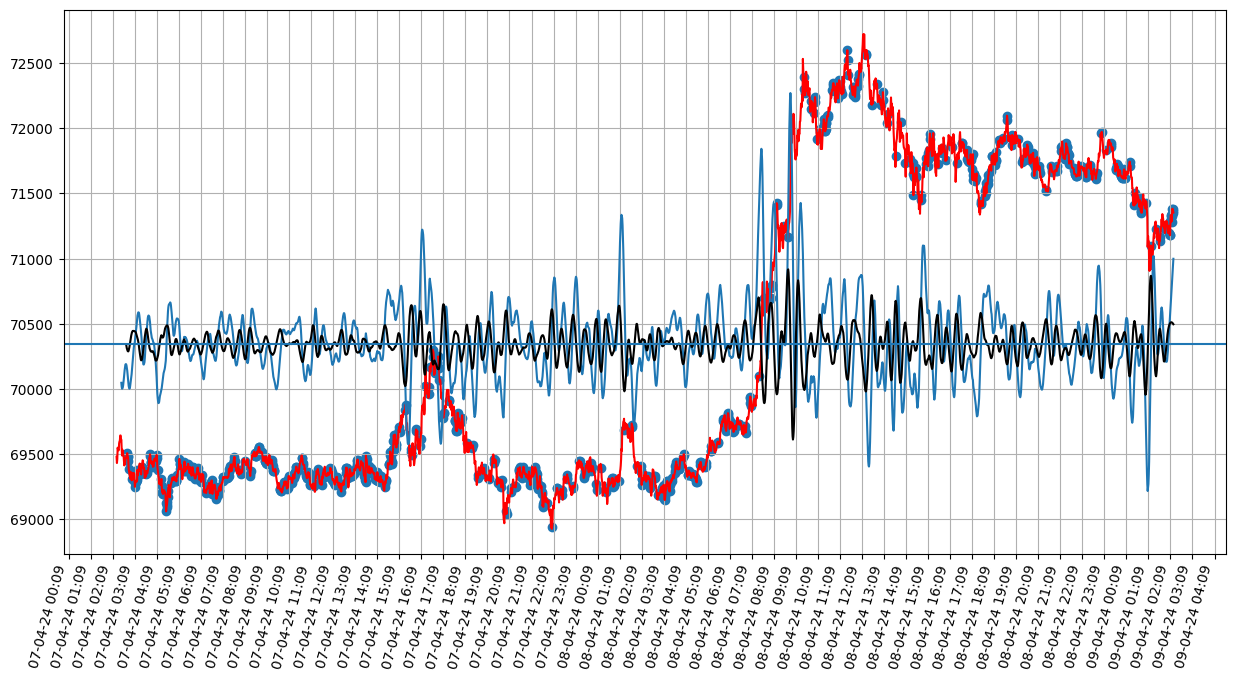

In [2]:
import pandas as pd
import os
import numpy as np
from datetime import datetime
import sympy as sp
import scipy as sc
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

## Conexión con Binance para descargar la lista de pares que binance maneja
from binance import Client
client = Client()


##################################################################################################################################
# Descarga y limpieza de datos de 5 días en adelante
##################################################################################################################################
recent_data = pd.DataFrame(client.get_historical_klines('BTCUSDT','1m','2 day ago UTC'))
recent_data = recent_data.iloc[:,:6]
recent_data.columns = ['Tiempo','Open','High','Low','Close','Volume']
recent_data['Tiempo'] = pd.to_datetime(recent_data.Tiempo,unit='ms')
#recent_data['Tiempo'] = recent_data.Tiempo.astype('datetime64')
recent_data = recent_data.set_index('Tiempo')
recent_data = recent_data.astype(float)
recent_data = recent_data.reset_index()
recent_data['Interpolacion'] = sc.signal.savgol_filter(recent_data.Open,25,3)
recent_data['Primer_Derivada'] = recent_data.Interpolacion.diff()
recent_data['PD_Interpolacion'] = sc.signal.savgol_filter(recent_data.Primer_Derivada,25,3)
recent_data['Segunda_Derivada'] = recent_data.PD_Interpolacion.diff()
recent_data['SD_Interpolacion'] = sc.signal.savgol_filter(recent_data.Segunda_Derivada,25,3)
recent_data['Tercer_Derivada'] = recent_data.SD_Interpolacion.diff()
recent_data['TD_Interpolacion'] = sc.signal.savgol_filter(recent_data.Tercer_Derivada,25,3)




##################################################################################################################################
# Gráfica final del backtesting sobre nuestro análisis con puntos de compra y venta.
##################################################################################################################################
initial_date_index = recent_data[recent_data.Tiempo == datetime.strptime(str(recent_data.Tiempo[:1].item()),'%Y-%m-%d %H:%M:%S')].index.item()
final_date_index = recent_data[recent_data.Tiempo == datetime.strptime(str(recent_data.Tiempo[-1:].item()),'%Y-%m-%d %H:%M:%S')].index.item()


min_max_sd = pd.DataFrame(columns=['Derivada'])
min_max_sd['Derivada'] = recent_data[initial_date_index:final_date_index].SD_Interpolacion.diff()
lista_min_max = min_max_sd[(min_max_sd['Derivada'] >= -0.1) & (min_max_sd['Derivada'] <= 0.1)]
indices_min_max = lista_min_max.index.tolist()


######################################################################
# Agregamos el código necesario para encontrar los puntos exactos mínimos y máximos
######################################################################
drlist = []
lista_min_max = lista_min_max.reset_index()
lista_min_max.columns = ['indice','Derivada']
mp = recent_data.Open[initial_date_index:final_date_index].mean()


for i in range(1,len(lista_min_max)-1):
    if (recent_data.SD_Interpolacion.diff()[lista_min_max.indice[i-1]] >= lista_min_max.Derivada[i]) & (recent_data.SD_Interpolacion.diff()[lista_min_max.indice[i+1]] >= lista_min_max.Derivada[i]) & (recent_data.SD_Interpolacion[i]*100 < (mp - np.std(recent_data.SD_Interpolacion)*10)):
        drlist.append(i)
#        minlist.append(lista_min_max[i])
    elif (recent_data.SD_Interpolacion.diff()[lista_min_max.indice[i-1]] <= lista_min_max.Derivada[i]) & (recent_data.SD_Interpolacion.diff()[lista_min_max.indice[i+1]] <= lista_min_max.Derivada[i]) & (recent_data.SD_Interpolacion[i]*100 > (mp + np.std(recent_data.SD_Interpolacion)*10)):
        drlist.append(i)
#        maxlist.append(lista_min_max[i])


######################################################################
# Gráficas resultantes de los análisis anteriores.
######################################################################
# plt.axvline(halving_dates['Halving_Dates'][2])
# plt.axvline(halving_dates['Halving_Dates'][3])
plt.figure(figsize=(15,8))
plt.plot(recent_data.Tiempo[initial_date_index:final_date_index],recent_data.Open[initial_date_index:final_date_index].multiply(1),color='red')
plt.plot(recent_data.Tiempo[initial_date_index:final_date_index],recent_data.PD_Interpolacion[initial_date_index:final_date_index].multiply(30)+mp)
plt.plot(recent_data.Tiempo[initial_date_index:final_date_index],recent_data.SD_Interpolacion[initial_date_index:final_date_index].multiply(100)+mp,color='k')
# for i in recent_data.Tiempo.iloc[lista_min_max]:
#     plt.axvline(i)
plt.scatter(recent_data.Tiempo.iloc[indices_min_max],recent_data.Open.iloc[indices_min_max])
plt.grid(visible=True)

# Set minor tick locations.
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=60))
# plt.gca().xaxis.set_minor_locator(minorLocator)
plt.gcf().autofmt_xdate()
# Set grid to use minor tick locations. 
plt.grid(which = 'minor')
plt.xticks(rotation=75)
plt.axhline(mp)
# plt.axhline(np.std(recent_data.SD_Interpolacion)*10 + mp)
# plt.axhline(mp - np.std(recent_data.SD_Interpolacion)*10)
# plt.axvline(6500)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

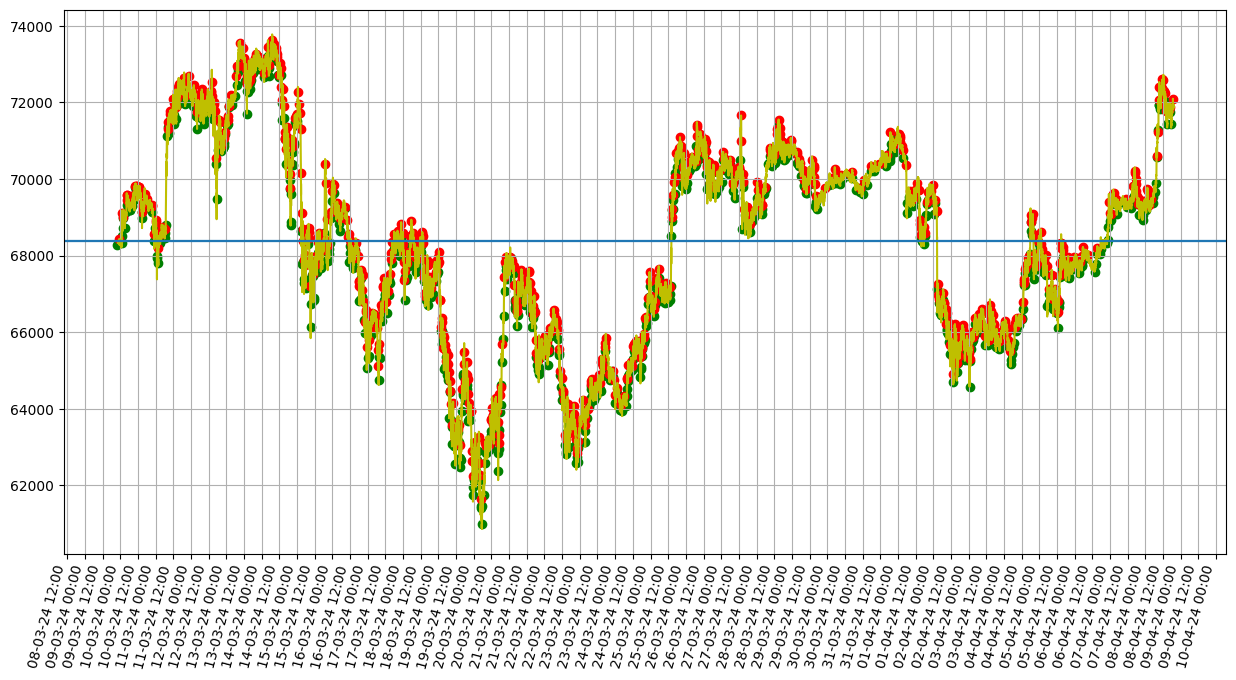

In [31]:
################################################################################################################################################################################
# Importamos las librerías necesarias y generamos conexión con Binance para descargar la lista de pares que binance maneja.
################################################################################################################################################################################
import pandas as pd
import os
import numpy as np
from datetime import datetime
import sympy as sp
import scipy as sc
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from binance import Client

client = Client()

##################################################
# Lista de parámetros.
##################################################
# Parámetros de interpolación.
###################################
smooth_interval = 25
smooth_exp = 3
###################################
# Parámetros de estrategia.
###################################
rango = 100
std_mult = 50
z_aprox = 0.07

##################################################################################################################################
# Descarga y limpieza de datos de X días atrás a hoy.
##################################################################################################################################
recent_data = pd.DataFrame(client.get_historical_klines('BTCUSDT','1m','30 day ago UTC'))
recent_data = recent_data.iloc[:,:6]
recent_data.columns = ['Tiempo','Open','High','Low','Close','Volume']
recent_data['Tiempo'] = pd.to_datetime(recent_data.Tiempo,unit='ms')
recent_data = recent_data.set_index('Tiempo')
recent_data = recent_data.astype(float)
recent_data = recent_data.reset_index()

##################################################
# Interpolación (suavizado)  del Precio (OPEN) con SciPy y obtención de derivadas con su respectiva interpolación.
##################################################
recent_data['Interpolacion'] = sc.signal.savgol_filter(recent_data.Open,smooth_interval,3)
recent_data['Primer_Derivada'] = recent_data.Interpolacion.diff()/(recent_data.Tiempo.diff()/np.timedelta64(1, 's'))
recent_data['PD_Interpolacion'] = sc.signal.savgol_filter(recent_data.Primer_Derivada,smooth_interval,3)
recent_data['Segunda_Derivada'] = recent_data.PD_Interpolacion.diff()/(recent_data.Tiempo.diff()/np.timedelta64(1, 's'))
recent_data['SD_Interpolacion'] = sc.signal.savgol_filter(recent_data.Segunda_Derivada,smooth_interval,3)
recent_data['Tercer_Derivada'] = recent_data.SD_Interpolacion.diff()/(recent_data.Tiempo.diff()/np.timedelta64(1, 's'))
recent_data['TD_Interpolacion'] = sc.signal.savgol_filter(recent_data.Tercer_Derivada,smooth_interval,3)

######################################################################
# Agregamos el código necesario para encontrar los puntos exactos mínimos y máximos
######################################################################
initial_date_index = recent_data[recent_data.Tiempo == datetime.strptime(str(recent_data.Tiempo[:1].item()),'%Y-%m-%d %H:%M:%S')].index.item() + rango
final_date_index = recent_data[recent_data.Tiempo == datetime.strptime(str(recent_data.Tiempo[-1:].item()),'%Y-%m-%d %H:%M:%S')].index.item() - rango

# initial_date_index = recent_data[recent_data.Tiempo == datetime.strptime('2024-04-04 05:48:00','%Y-%m-%d %H:%M:%S')].index.item() #+ rango
# final_date_index = recent_data[recent_data.Tiempo == datetime.strptime('2024-04-06 05:47:00','%Y-%m-%d %H:%M:%S')].index.item() #- rango

lista_min_max = recent_data[initial_date_index:final_date_index][(recent_data[initial_date_index:final_date_index].TD_Interpolacion >= -z_aprox) & (recent_data[initial_date_index:final_date_index].TD_Interpolacion <= z_aprox)]
indices_min_max = lista_min_max.index.tolist()

max_points_idx = []
min_points_idx = []
pmin = 0
pmax = 0

for PMSD in indices_min_max:
    if recent_data.SD_Interpolacion[PMSD:PMSD+1].item() > 0:
        if (abs(recent_data.SD_Interpolacion[PMSD]*100) > abs(np.std(recent_data.SD_Interpolacion)*std_mult)) & ((recent_data.PD_Interpolacion[PMSD]*10) > abs(np.std(recent_data.SD_Interpolacion)*std_mult)):
            pmax = recent_data.SD_Interpolacion[PMSD]
        for i in range(rango+1):
            if (i > PMSD) or (PMSD+i >= indices_min_max[-1:][0]):
                break
            elif ((recent_data.SD_Interpolacion[PMSD-i] > pmax)) & ((abs(recent_data.SD_Interpolacion[PMSD-i]*80)) > abs(np.std(recent_data.SD_Interpolacion)*std_mult)) & ((recent_data.PD_Interpolacion[PMSD-i]*10) > abs(np.std(recent_data.SD_Interpolacion)*std_mult)):
                pmax_idx = PMSD-i
            elif ((recent_data.SD_Interpolacion[PMSD+i] > pmax)) & ((abs(recent_data.SD_Interpolacion[PMSD+i]*80)) > abs(np.std(recent_data.SD_Interpolacion)*std_mult)) & ((recent_data.PD_Interpolacion[PMSD+i]*10) > abs(np.std(recent_data.SD_Interpolacion)*std_mult)):
                pmax_idx = PMSD+i
        max_points_idx.append(pmax_idx)
    elif recent_data.SD_Interpolacion[PMSD:PMSD+1].item() < 0:
        if (abs(recent_data.SD_Interpolacion[PMSD]*100) > abs(np.std(recent_data.SD_Interpolacion)*std_mult)) & ((recent_data.PD_Interpolacion[PMSD]*10) < -abs(np.std(recent_data.SD_Interpolacion)*std_mult)):
            pmin = recent_data.SD_Interpolacion[PMSD]
        for i in range(rango+1):
            if (i > PMSD) or (PMSD+i >= indices_min_max[-1:][0]):
                break
            elif ((recent_data.SD_Interpolacion[PMSD-i] < pmin)) & (abs(recent_data.SD_Interpolacion[PMSD-i]*80) > abs(np.std(recent_data.SD_Interpolacion)*std_mult)) & ((recent_data.PD_Interpolacion[PMSD-i]*10) < -abs(np.std(recent_data.SD_Interpolacion)*std_mult)):
                pmin_idx = PMSD-i
            elif ((recent_data.SD_Interpolacion[PMSD+i] < pmin)) & (abs(recent_data.SD_Interpolacion[PMSD+i]*80) > abs(np.std(recent_data.SD_Interpolacion)*std_mult)) & ((recent_data.PD_Interpolacion[PMSD+i]*10) < -abs(np.std(recent_data.SD_Interpolacion)*std_mult)):
                pmin_idx = PMSD+i
        min_points_idx.append(pmin_idx)
max_points_idx = list(set(max_points_idx))
min_points_idx = list(set(min_points_idx))
max_points_idx.sort()
min_points_idx.sort()
close_points_max = []
close_points_min = []
for lista in [max_points_idx,min_points_idx]:
    for i in range(len(lista)-1):
        if lista[i+1]-lista[i] <= 2:
            if lista == max_points_idx:
                close_points_max.append(i+1)
            else:
                close_points_min.append(i+1)
    if lista == max_points_idx:
        for idx in sorted(close_points_max,reverse=True):
            del lista[idx]
    else:
        for idx in sorted(close_points_min,reverse=True):
            del lista[idx]

######################################################################
# Ahora ya podemos visualizar los resultados con el siguiente código.
######################################################################
mp = recent_data.Open[initial_date_index:final_date_index].mean()
plt.figure(figsize=(15,8))
plt.plot(recent_data.Tiempo[initial_date_index:final_date_index],recent_data.Open[initial_date_index:final_date_index].multiply(1),color='y')
# plt.plot(recent_data.Tiempo[initial_date_index:final_date_index],recent_data.PD_Interpolacion[initial_date_index:final_date_index].multiply(10)+mp,'purple')
# plt.plot(recent_data.Tiempo[initial_date_index:final_date_index],recent_data.SD_Interpolacion[initial_date_index:final_date_index].multiply(80)+mp,color='k')
# plt.plot(recent_data.Tiempo[initial_date_index:final_date_index],recent_data.TD_Interpolacion[initial_date_index:final_date_index].multiply(300)+mp,color='y')
plt.scatter(recent_data.Tiempo.iloc[max_points_idx],recent_data.Open.iloc[max_points_idx],color='g')
plt.scatter(recent_data.Tiempo.iloc[min_points_idx],recent_data.Open.iloc[min_points_idx],color='r')
plt.grid(visible=True)

# Set minor tick locations.
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=12))
plt.gcf().autofmt_xdate()

# Set grid to use minor tick locations. 
plt.grid(which = 'minor')
plt.xticks(rotation=75)
plt.axhline(mp)
plt.axhline(np.std(recent_data.SD_Interpolacion)*std_mult + mp)
plt.axhline(mp - np.std(recent_data.SD_Interpolacion)*std_mult)
# plt.axvline(datetime.strptime('2024-04-04 09:59:00','%Y-%m-%d %H:%M:%S'))
plt.show

In [33]:
pmax_df = recent_data.iloc[max_points_idx].iloc[:,:2]
pmax_df['Accion'] = 'C'
pmin_df = recent_data.iloc[min_points_idx].iloc[:,:2]
pmin_df['Accion'] = 'V'
vc_df = pd.concat([pmax_df,pmin_df],axis=1)
vc_df = vc_df.reset_index()
vc_df = vc_df.set_index('index')
vc_df = pd.concat([pmax_df,pmin_df],axis=0)
vc_df = vc_df.sort_index()
del_idx = []
vc_df = vc_df.reset_index()
for i in vc_df.index:
    try:
        if vc_df.Accion[i+1] == vc_df.Accion[i]:
            del_idx.append(i+1)
    except:
        pass
vc_df.drop(del_idx,inplace=True)
vc_df = vc_df.reset_index(drop=True)
vc_df['Diferencia_Precio_USDT'] = pd.Series(dtype='float')
for i in range(len(vc_df)-1):
    vc_df['Diferencia_Precio_USDT'][i+1] = (vc_df.Open[i+1] - vc_df.Open[i]) * 1
profits = 0
for i in range(len(vc_df)-1):
    if vc_df.Accion[i] == 'C' and vc_df.Diferencia_Precio_USDT[i+1] > 0:
        profits += vc_df.Diferencia_Precio_USDT[i+1]
    elif vc_df.Accion[i] == 'C' and vc_df.Diferencia_Precio_USDT[i+1] < 0:
        profits -= vc_df.Diferencia_Precio_USDT[i+1]
    elif vc_df.Accion[i] == 'V' and vc_df.Diferencia_Precio_USDT[i+1] > 0:
        profits -= vc_df.Diferencia_Precio_USDT[i+1]
    elif vc_df.Accion[i] == 'V' and vc_df.Diferencia_Precio_USDT[i+1] < 0:
        profits += (-1)*(vc_df.Diferencia_Precio_USDT[i+1])
profits

C:\Users\tinma\AppData\Local\Temp\ipykernel_29224\2566828253.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vc_df['Diferencia_Precio_USDT'][i+1] = (vc_df.Open[i+1] - vc_df.Open[i]) * 1


475348.5400000002

In [13]:
vc_df

,index,Tiempo,Open,Accion,Diferencia_Precio_USDT
0,945,2024-04-04 04:27:00,65160.00,C,NaN
1,994,2024-04-04 05:16:00,65514.08,V,1.77040
2,1007,2024-04-04 05:29:00,65422.80,C,-0.45640
3,1123,2024-04-04 07:25:00,66137.76,V,3.57480
4,1154,2024-04-04 07:56:00,66045.75,C,-0.46005
...,...,...,...,...,...
109,3763,2024-04-06 03:25:00,67832.31,V,1.48445
110,3785,2024-04-06 03:47:00,67666.67,C,-0.82820
111,3875,2024-04-06 05:17:00,67993.97,V,1.63650
112,3881,2024-04-06 05:23:00,67874.51,C,-0.59730


In [36]:
recent_data

,Tiempo,Open,High,Low,Close,Volume,Interpolacion,Primer_Derivada,PD_Interpolacion,Segunda_Derivada,SD_Interpolacion,Tercer_Derivada,TD_Interpolacion
0,2024-04-06 22:16:00,68462.00,68477.16,68461.99,68477.15,4.32397,68425.669323,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-04-06 22:17:00,68477.15,68477.16,68450.43,68450.43,5.03848,68432.422391,6.753068,NaN,NaN,NaN,NaN,NaN
2,2024-04-06 22:18:00,68450.43,68450.44,68422.00,68422.00,4.50410,68441.496770,9.074379,NaN,NaN,NaN,NaN,NaN
3,2024-04-06 22:19:00,68422.00,68422.01,68418.97,68418.98,2.28443,68452.608764,11.111993,NaN,NaN,NaN,NaN,NaN
4,2024-04-06 22:20:00,68418.98,68439.87,68412.13,68439.87,9.12093,68465.474675,12.865911,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2875,2024-04-08 22:11:00,71694.00,71700.00,71672.00,71672.01,10.92264,71693.741705,-3.484282,-3.646842,-1.351524,-1.446779,-0.064220,-0.071284
2876,2024-04-08 22:12:00,71672.00,71688.15,71672.00,71676.99,8.58952,71688.866723,-4.874982,-5.050950,-1.404108,-1.479156,-0.032377,-0.037702
2877,2024-04-08 22:13:00,71676.99,71696.00,71660.00,71695.99,11.84659,71682.505105,-6.361617,-6.495385,-1.444436,-1.476132,0.003024,0.001035
2878,2024-04-08 22:14:00,71695.99,71696.00,71654.29,71664.22,6.43136,71674.560918,-7.944187,-7.967893,-1.472508,-1.434146,0.041986,0.045144


In [98]:
df_test = pd.read_csv('../../csvs/streaming/BTCUSDT.csv')
df_test

,2024-04-09 15:01:09.487,BTCUSDT,69279.23
0,2024-04-09 15:01:10.474,BTCUSDT,69256.02
1,2024-04-09 15:01:11.300,BTCUSDT,69256.01
2,2024-04-09 15:01:12.423,BTCUSDT,69247.73
3,2024-04-09 15:01:13.443,BTCUSDT,69233.28
4,2024-04-09 15:01:14.461,BTCUSDT,69235.90
...,...,...,...
167,2024-04-09 15:12:36.926,BTCUSDT,68716.00
168,2024-04-09 15:12:37.815,BTCUSDT,68740.00
169,2024-04-09 15:12:38.905,BTCUSDT,68728.96
170,2024-04-09 15:12:39.740,BTCUSDT,68716.01
